In [1]:
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Activation, Lambda
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from config_reader import config_reader
import scipy
import math

C:\Users\M.Hemanth\Anaconda3\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Helper functions to create a model

In [2]:
def relu(x): 
    return Activation('relu')(x)

def conv(x, nf, ks, name):
    x1 = Conv2D(nf, (ks, ks), padding='same', name=name)(x)
    return x1

def pooling(x, ks, st, name):
    x = MaxPooling2D((ks, ks), strides=(st, st), name=name)(x)
    return x

def vgg_block(x):
     
    # Block 1
    x = conv(x, 64, 3, "conv1_1")
    x = relu(x)
    x = conv(x, 64, 3, "conv1_2")
    x = relu(x)
    x = pooling(x, 2, 2, "pool1_1")

    # Block 2
    x = conv(x, 128, 3, "conv2_1")
    x = relu(x)
    x = conv(x, 128, 3, "conv2_2")
    x = relu(x)
    x = pooling(x, 2, 2, "pool2_1")
    
    # Block 3
    x = conv(x, 256, 3, "conv3_1")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_2")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_3")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_4")
    x = relu(x)    
    x = pooling(x, 2, 2, "pool3_1")
    
    # Block 4
    x = conv(x, 512, 3, "conv4_1")
    x = relu(x)    
    x = conv(x, 512, 3, "conv4_2")
    x = relu(x)    
    
    # Additional non vgg layers
    x = conv(x, 256, 3, "conv4_3_CPM")
    x = relu(x)
    x = conv(x, 128, 3, "conv4_4_CPM")
    x = relu(x)
    
    return x

def stage1_block(x, num_p, branch):
    
    # Block 1        
    x = conv(x, 128, 3, "conv5_1_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 128, 3, "conv5_2_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 128, 3, "conv5_3_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 512, 1, "conv5_4_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, num_p, 1, "conv5_5_CPM_L%d" % branch)
    
    return x

def stageT_block(x, num_p, stage, branch):
        
    # Block 1        
    x = conv(x, 128, 7, "Mconv1_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv2_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv3_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv4_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv5_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 1, "Mconv6_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, num_p, 1, "Mconv7_stage%d_L%d" % (stage, branch))
    
    return x

Create keras model and load weights

In [3]:
weights_path = "model/keras/model.h5" # orginal weights converted from caffe
#weights_path = "training/weights.best.h5" # weights tarined from scratch 

input_shape = (None,None,3)

img_input = Input(shape=input_shape)

stages = 6
np_branch1 = 38
np_branch2 = 19

img_normalized = Lambda(lambda x: x / 256 - 0.5)(img_input)  # [-0.5, 0.5]

# VGG
stage0_out = vgg_block(img_normalized)

# stage 1
stage1_branch1_out = stage1_block(stage0_out, np_branch1, 1)
stage1_branch2_out = stage1_block(stage0_out, np_branch2, 2)
x = Concatenate()([stage1_branch1_out, stage1_branch2_out, stage0_out])

# stage t >= 2
for sn in range(2, stages + 1):
    stageT_branch1_out = stageT_block(x, np_branch1, sn, 1)
    stageT_branch2_out = stageT_block(x, np_branch2, sn, 2)
    if (sn < stages):
        x = Concatenate()([stageT_branch1_out, stageT_branch2_out, stage0_out])

model = Model(img_input, [stageT_branch1_out, stageT_branch2_out])
model.load_weights(weights_path)

Load a sample image

In [4]:
%matplotlib inline
import cv2
import matplotlib
import pylab as plt
import numpy as np
import util
import time
import os
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.metrics import accuracy_score
from scipy.ndimage.filters import gaussian_filter
import sys
from tkinter import *
from tkinter import messagebox

In [5]:
def readData():
#    cwd=os.getcwd()
    os.chdir("C:/Users/M.Hemanth/AnacondaProjects/keras_Realtime_Multi-Person_Pose_Estimation-master")
    file= 'data.csv'
    x1 = pd.read_csv(file)
    #x1=pd.ExcelFile(file)
    #df1=x1.parse('Sheet1')
    #print(df1)
    npdata=x1.as_matrix()
    #print("hello")
    return npdata
def norm_01(data):
    #standardizind mean 0 variance 1
    norm=[]
    for i in range(len(data)):
        cur=data[i,:]
        s_data= (cur - cur.mean()) / cur.std()
        #normalizing [0,1] min-max scaling
        s_data = (s_data - s_data.min()) / (s_data.max() - s_data.min())
        norm.append(s_data)
    norm=np.asarray(norm)    
    return norm
def num_to_exer(num):
    ans="none"
    if(num==1):
        ans='armcurl'
    elif(num==2):
        ans='lunge'
    elif(num==3):
        ans='squat'
    elif(num==4):
        ans='pushup'
    return ans
def discretize(classlabels):
    for i in range(0,len(classlabels)):
        #print(classlabels[i])
        if(classlabels[i]=='armcurl'):
            classlabels[i]=1
        elif(classlabels[i]=='lunge'):
            classlabels[i]=2
        elif(classlabels[i]=='squat'):
            classlabels[i]=3
        elif(classlabels[i]=='pushup'):
            classlabels[i]=4
        elif(classlabels[i]==0):
            continue
        else:
            print("error")
    return classlabels
def convert_to_points(data):
    moddata=[]
    #print(data.shape)
    for i in range(0,len(data)):
        cur=[]
        for j in range(0,data.shape[1],2):
            point=[]
            point.append(data[i][j])
            point.append(data[i][j+1])
            cur.append(point)
        moddata.append(cur)
    return moddata 
def generate_matrix(data):
    val=data[...,2:]
    #print(val.shape,data.shape)
    lab=data[...,1]
    lab=discretize(lab)
    val=norm_01(val)
    #print(val.shape,data.shape)
    moddata=convert_to_points(val) 
    svmfeeddata=calc_dist(moddata)
    #svmfeeddata=np.hstack((val,svmfeeddata)).tolist() #comment this line if you dont want to feed the points (x,y) to the SVM.
    svmfeeddata=calc_plane_dist(moddata,svmfeeddata) 
    svmfeeddata=np.asarray(svmfeeddata,float)
    lab=lab.astype('int')
    return svmfeeddata,lab   
def calc_dist(data):
    newdata=[]
    for i in range(0,len(data)):
        dist=[]
        for j in range(0,len(data[i])-1):
            for k in range(j+1,len(data[i])):
                calc=((data[i][j][0]-data[i][k][0])**2 + (data[i][j][1]-data[i][k][1])**2)**(1/2.0)
                calc=calc*10000
                dist.append(calc)
        newdata.append(dist)
    return newdata   
     
def dist_point_plane(p0, p1, p2): 
    x0, y0 = p0
    x1, y1 = p1
    x2, y2 = p2
    nom = abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
    denom = ((y2 - y1)**2 + (x2 - x1) ** 2) ** 0.5
    if(denom==0):
        result=((x0-x2)**2 + (y2-y0)**2)**(1/2.0)
    else:
        result = nom / denom
    result=result*10000    
    return result

def calc_plane_dist(data,svmfeeddata):
    for i in range(0,len(data)):
        for j in range(0,len(data[i])-1):
            for k in range(j+1,len(data[i])):
                    for m in range(0,len(data[i])):
                        d = dist_point_plane(data[i][j],data[i][k],data[i][m])
                        svmfeeddata[i].append(d)
    return svmfeeddata
   
try:
    #np.set_printoptions(threshold=np.nan)
    data=readData()
    dataview=data.tolist()
    kf = KFold(n_splits=4,shuffle=True)
    conf_mat=np.full((4,4),0)
    scores=[]
    for train_index, test_index in kf.split(data):
        ftrain, ftest = data[train_index], data[test_index]
#    ftrain,ftest = train_test_split(data,0.7)
        #print(ftrain.shape)
        #print(ftrain[0])
        train_d,train_l=generate_matrix(ftrain)
        clf = svm.LinearSVC(C=3.5)
#        clf = svm.SVC(decision_function_shape='ovo',tol=0.00001,degree=3)
        clf.fit(train_d, train_l)
except:
    print("error")     


In [28]:
#video_capture = cv2.VideoCapture(0)
#frameWidth = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
#frameHeight = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
#j=0
#while True:
#    if j%10==0:
start_time=time.time()
#ret, framereal = video_capture.read()
test_image = 'data/frames/001 001.jpg'
oriImg = cv2.imread(test_image) # B,G,R order
#plt.imshow(oriImg[:,:,[2,1,0]])
#print(j)
param, model_params = config_reader()
multiplier = [x * model_params['boxsize'] / oriImg.shape[0] for x in param['scale_search']]
heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 19))
#print(len(multiplier))
for m in range(len(multiplier)):
    scale = multiplier[m]

    imageToTest = cv2.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    imageToTest_padded, pad = util.padRightDownCorner(imageToTest, model_params['stride'], model_params['padValue'])        

    input_img = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,0,1,2)) # required shape (1, width, height, channels) 
    #print("Input shape: " + str(input_img.shape))  
    print('starttook '+ str(1000 * (time.time() - start_time))+' ms')
    output_blobs = model.predict(input_img)
    #print("Output shape (heatmap): " + str(output_blobs[1].shape))
    print('stoptook '+ str(1000 * (time.time() - start_time))+' ms')
    # extract outputs, resize, and remove padding
    heatmap = np.squeeze(output_blobs[1]) # output 1 is heatmaps
    heatmap = cv2.resize(heatmap, (0,0), fx=model_params['stride'], fy=model_params['stride'], interpolation=cv2.INTER_CUBIC)
    heatmap = heatmap[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
    heatmap = cv2.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
    heatmap_avg = heatmap_avg + heatmap / len(multiplier)

#print('took '+ str(1000 * (time.time() - start_time))+' ms')
#print(heatmap_avg)
all_peaks = []
peak_counter = 0

for part in range(19-1):
    map_ori = heatmap_avg[:,:,part]
    map = gaussian_filter(map_ori, sigma=3)

    map_left = np.zeros(map.shape)
    map_left[1:,:] = map[:-1,:]
    map_right = np.zeros(map.shape)
    map_right[:-1,:] = map[1:,:]
    map_up = np.zeros(map.shape)
    map_up[:,1:] = map[:,:-1]
    map_down = np.zeros(map.shape)
    map_down[:,:-1] = map[:,1:]

    peaks_binary = np.logical_and.reduce((map>=map_left, map>=map_right, map>=map_up, map>=map_down, map > param['thre1']))
    peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0])) # note reverse
    peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
    id = range(peak_counter, peak_counter + len(peaks))
    peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]

    all_peaks.append(peaks_with_score_and_id)
    peak_counter += len(peaks)
resultpeaks=[]
for i in range(len(all_peaks)):
    for j in range(len(all_peaks[i])):
        resultpeaks.append(list(all_peaks[i][j][0:2]))
#print(resultpeaks)


starttook 203.51338386535645 ms
stoptook 2165.7299995422363 ms
starttook 2524.686098098755 ms
stoptook 9675.770282745361 ms
starttook 9977.511405944824 ms
stoptook 24550.28200149536 ms
starttook 24869.12965774536 ms
stoptook 49837.55826950073 ms


Heatmap for right knee. Note that the body part is encoded in the 3th channel so in this case right knee is 
at index 9. All body parts are defined in config: 
part_str = [nose, neck, Rsho, Relb, Rwri, Lsho, Lelb, Lwri, Rhip, Rkne, Rank, Lhip, Lkne, Lank, Leye, Reye, Lear, Rear, pt19]

squat
took 199777.43697166443 ms


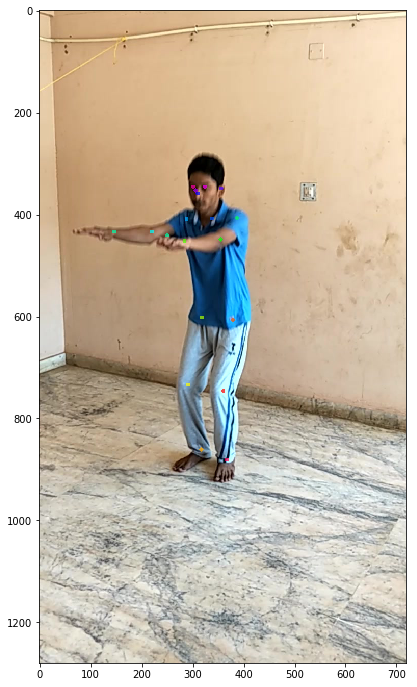

In [31]:
testdata=np.zeros((1,22))
testdata[0][2]=resultpeaks[0][0]
testdata[0][3]=resultpeaks[0][1]
testdata[0][4]=resultpeaks[6][0]
testdata[0][5]=resultpeaks[6][1]
testdata[0][6]=resultpeaks[3][0]
testdata[0][7]=resultpeaks[3][1]
testdata[0][8]=resultpeaks[7][0]
testdata[0][9]=resultpeaks[7][1]
testdata[0][10]=resultpeaks[4][0]
testdata[0][11]=resultpeaks[4][1]
testdata[0][12]=(resultpeaks[8][0]+resultpeaks[11][0])/2
testdata[0][13]=(resultpeaks[8][1]+resultpeaks[11][1])/2
testdata[0][14]=resultpeaks[12][0]
testdata[0][15]=resultpeaks[12][1]
testdata[0][16]=resultpeaks[9][0]
testdata[0][17]=resultpeaks[9][1]
testdata[0][18]=resultpeaks[13][0]
testdata[0][19]=resultpeaks[13][1]
testdata[0][20]=resultpeaks[10][0]
testdata[0][21]=resultpeaks[10][1]
#testdata=np.asmatrix(testdata)
rawdata=convert_to_points(testdata)
raw1=[]
for i in range(len(rawdata)):
    a=[int(rawdata[0][i][0]),int(rawdata[0][i][1])]
    raw1.append(tuple(a))
#print(testdata,rawdata)
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
cmap = matplotlib.cm.get_cmap('hsv')

canvas = cv2.imread(test_image) # B,G,R order

for i in range(18):
    rgba = np.array(cmap(1 - i/18. - 1./36))
    rgba[0:3] *= 255
    for j in range(len(all_peaks[i])):
        cv2.circle(canvas, all_peaks[i][j][0:2], 4, colors[i], thickness=-1)

to_plot = cv2.addWeighted(oriImg, 0.3, canvas, 0.7, 0)
#print(all_peaks,len(all_peaks))
plt.imshow(to_plot[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)
testdata,testl=generate_matrix(testdata)

result=clf.predict(testdata)
if result[0]==1:
    fr='arm curl'
elif result[0]==2:
    fr='lunge'
elif result[0]==3:
    fr='squat'
elif result[0]==4:
    fr='push up'
print(fr)
print('took '+ str(1000 * (time.time() - start_time))+' ms')
#cv2.putText(img = oriImg, text = fr, org = (int(frameWidth - 100),int(50)), fontFace = cv2.FONT_HERSHEY_DUPLEX, fontScale = 1, 
#                    color = (0, 255, 0))
#cv2.imshow('Video', oriImg)
#j=j+1
#if cv2.waitKey(1) & 0xFF == ord('q'):
#    break

#video_capture.release()
#cv2.destroyAllWindows()